In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

from support import compute_loss_accuracy, accuracy_number, compute_error_model, Flattener

Загружаем тестовые данные

In [3]:
test_data  = dset.MNIST('./data/', train=False,
                    transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43],
                                               std=[0.20])
                       ]))

Выбираем на каком железе тестировать (CPU vs GPU)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("CUDA")
else:
    device = torch.device('cpu')
    print("CPU")

CPU


Загружаем тренированную модель

In [5]:
load_model = torch.load("./model_v3.pt", device)
load_model.eval()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flattener()
  (9): Linear(in_features=576, out_features=10, bias=True)
)

### Тестируем!

In [6]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
test_loss, test_accuracy = compute_loss_accuracy(load_model, test_loader, loss, device)
print("Test loss: %f, accuracy: %f" % (test_loss, test_accuracy))

Test loss: 0.029164, accuracy: 0.991100


Точность для каждой цифры

In [6]:
for i in range(10):
  accuracy = accuracy_number(load_model, test_loader, i, device)
  print("Number: %i, accuracy: %f" % (i, accuracy))

Number: 0, accuracy: 0.993878
Number: 1, accuracy: 0.998238
Number: 2, accuracy: 0.992248
Number: 3, accuracy: 0.991089
Number: 4, accuracy: 0.993890
Number: 5, accuracy: 0.991031
Number: 6, accuracy: 0.990605
Number: 7, accuracy: 0.986381
Number: 8, accuracy: 0.987680
Number: 9, accuracy: 0.985134


Покажем рандомные предсказания

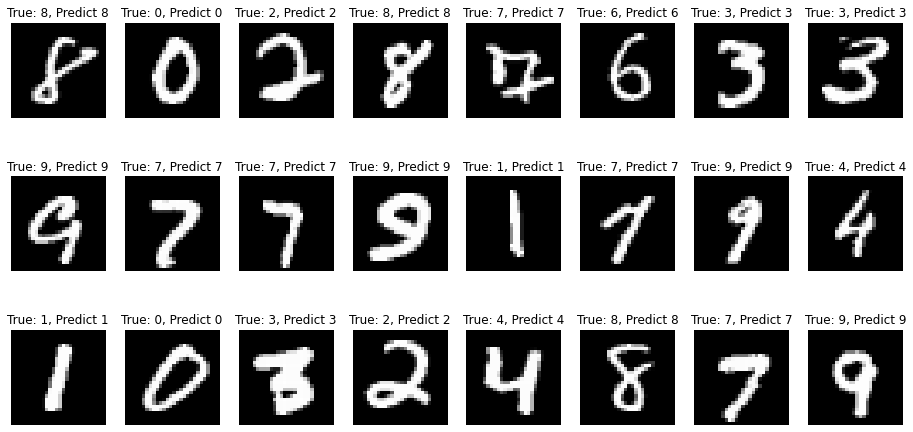

In [10]:
figure = plt.figure(figsize=(16, 8))
cols, rows = 8, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]

    img_gpu = img.to(device)

    y_probs = load_model(torch.unsqueeze(img_gpu, 0))
    y_hat = torch.argmax(y_probs, 1)

    figure.add_subplot(rows, cols, i)
    plt.title(f"True: {label}, Predict {int(y_hat)}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Покажем изображения, на которых модель ошибается

In [8]:
false_imgs, false_labels, true_labels = compute_error_model(load_model, test_loader, device)

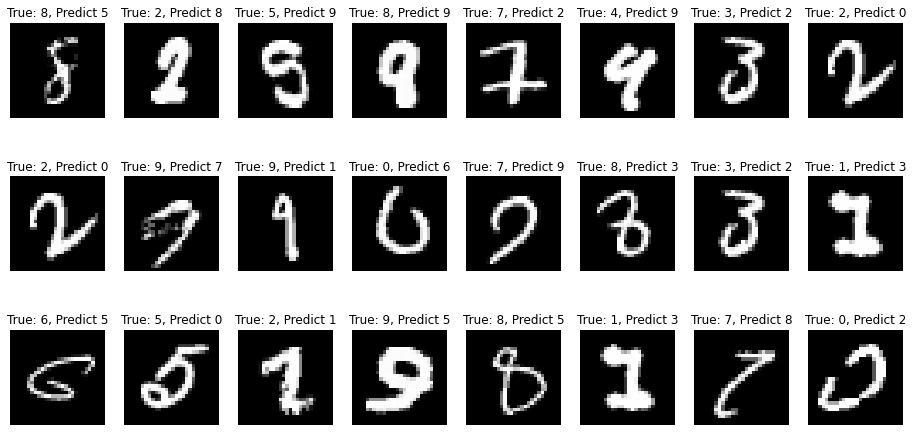

In [9]:
figure = plt.figure(figsize=(16, 8))
cols, rows = 8, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(false_imgs), size=(1,)).item()
    img, label_true, label_false = false_imgs[sample_idx], true_labels[sample_idx], false_labels[sample_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(f"True: {label_true}, Predict {int(label_false)}")
    plt.axis("off")
    plt.imshow(torch.tensor(img).squeeze(), cmap="gray")
plt.show()